# Example notebook on how to read NR/EOB waveforms

In [22]:
import glob, os, h5py,sys
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
import scipy,  json
from scipy.signal import argrelextrema
from scipy.interpolate import UnivariateSpline

import seaborn as sns


sns.set_palette("colorblind")
sns.set(style="white",font_scale=1.5)
colors=['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
golden = 1.6180339887498948482045868 
plt.rc('text', usetex=True) # Comment this out if you don't have LaTeX in your PATH!


# Load QC surrogate fits

def compute_h22OmegaOrbfromNRfile(NR_file, ModeList, sim_type='SXS'):

    hlm = {}
    amplm = {}
    phaselm = {}
    omegalm = {}
    tNRomegalm = {}

    fp = h5py.File(NR_file, "r")

    
    for l,m in ModeList:
        
        Alm = fp['amp_l'+str(l)+'_m'+str(m)+'/Y'][:]
        tAlm =fp['amp_l'+str(l)+'_m'+str(m)+'/X'][:]

        philm = fp['phase_l'+str(l)+'_m'+str(m)+'/Y'][:]
        tphilm =fp['phase_l'+str(l)+'_m'+str(m)+'/X'][:]

        tNR = fp['NRtimes'][:]
        iAlm = InterpolatedUnivariateSpline(tAlm,Alm)
        iphilm = InterpolatedUnivariateSpline(tphilm,-philm)

        amplm[l,m] = iAlm(tNR)
        phaselm[l,m] = iphilm(tNR)
        omegalm[l,m] = iphilm.derivative()(tNR)
        hlm[l,m] = amplm[l,m] * np.exp(1.j*phaselm[l,m])

    if sim_type == 'SXS':


        t_omega_orb = fp['Omega-vs-time/X'][:]
        tHorizon = fp['HorizonBTimes'][:]
        omega_orb = fp['Omega-vs-time/Y'][:]
        iOmega_orb = InterpolatedUnivariateSpline(t_omega_orb, omega_orb)

        om_orb = iOmega_orb(tHorizon)
        phi =  []

        for time in tHorizon:
            phi.append(iOmega_orb.integral(tHorizon[0],time))

        phase_orb = np.array(phi)

    else:
        phase_orb = None
        om_orb = None
        tHorizon = None
    
    fp.close()
    
    return tNR, tHorizon, hlm, amplm, phaselm, omegalm, om_orb, phase_orb


def compute_MaxMin(tHorizon, omega_orb):

    
    # for local maxima
    maxima = argrelextrema(omega_orb, np.greater) # Use A22 mode as it is cleaner than the frequency
    omega_orb_maxima = omega_orb[maxima]
    tH_maxima = tHorizon[maxima]

    # for local minima
    minima = argrelextrema(omega_orb, np.less)  # Use A22 mode as it is cleaner than the frequency

    omega_orb_minima =omega_orb[minima]
    tH_minima = tHorizon[minima]


    return tH_maxima, omega_orb_maxima, tH_minima, omega_orb_minima


def compute_MaxMin22(timeNR, omega22, amp22):
    
    if timeNR[0]<0:
        idx_insp = np.where(timeNR<0)[0]
    else:

        idx_max =np.argmax(amp22)
        amp_max = amp22[idx_max]
        idx_insp = np.where(timeNR<timeNR[idx_max])[0]

    amp22 = amp22[idx_insp]
    timeNR = timeNR[idx_insp]
    omega22 = omega22[idx_insp]
    # for local maxima
    maxima = argrelextrema(amp22, np.greater) # Use A22 mode as it is cleaner than the frequency
    omega_maxima = omega22[maxima]
    tNR_maxima = timeNR[maxima]

    # for local minima
    minima = argrelextrema(amp22, np.less)  # Use A22 mode as it is cleaner than the frequency

    omega_minima =omega22[minima]
    tNR_minima = timeNR[minima]

    return tNR_maxima, omega_maxima, tNR_minima, omega_minima


def compute_h22fromEOBfile(EOB_file):

    
    fp = h5py.File(EOB_file, "r")

    t_ecc = fp['data/t'][:]
    amp22_ecc = fp['data/hCoOrb/Amp_l2m2'][:]
    phi22_ecc = fp['data/hCoOrb/phi_l2m2'][:]
    
    t_nonecc = fp['data/t'][:]
    amp22_nonecc = fp['nonecc_data/hCoOrb/Amp_l2m2'][:]
    phi22_nonecc = fp['nonecc_data/hCoOrb/phi_l2m2'][:]
    
    iphi22_ecc = InterpolatedUnivariateSpline(t_ecc, phi22_ecc)
    iphi22_nonecc = InterpolatedUnivariateSpline(t_nonecc, phi22_nonecc)

    omega22_ecc = iphi22_ecc.derivative()(t_ecc)
    omega22_nonecc = iphi22_nonecc.derivative()(t_nonecc)
       
    fp.close()
    return t_ecc, amp22_ecc, phi22_ecc, omega22_ecc, t_nonecc, amp22_nonecc, phi22_nonecc, omega22_nonecc


In [16]:
# Set path to the etask_force directory
sim_dir = '/home/antoniramosbuades/git/eccentricitySXS/notebook/etask_force/'
run_dir = sim_dir + 'AEI_sxs_sims/'
#run_dir = sim_dir +'EOB_ns_data_for_sur/'
#run_dir = sim_dir +'ET_sims/'

# Choose Modes to take into account currently all l<= 8 modes
ModeList = []
lMax=6 # ET simulation only has up to l = 6
for l in np.arange(2,lMax+1):
    for m in np.arange(-l,l+1):
        ModeList.append([l,m])
        #ModeList.append([l,-m])
        
cases = glob.glob(run_dir+"*h5")

In [17]:
# Read one SXS simulation 
ii=0

nr_file = cases[ii]
simName=os.path.basename(nr_file).split('.h5')[0]

print(simName)

sim_type='SXS'

# Read 22 mode from the NR file
timeNR, tHorizon, hlm, amplm, phaselm, omegalm, omega_orb, phase_orb = compute_h22OmegaOrbfromNRfile(nr_file, 
                                                                                                     ModeList,
                                                                                                sim_type)
# Below some rough example on how to compute the eccentricity (not very )
# Compute from the orbital frequency 
iphase_orb = InterpolatedUnivariateSpline(tHorizon, phase_orb)

tH_maxima, omega_orb_maxima, tH_minima, omega_orb_minima = compute_MaxMin(tHorizon, omega_orb)
tNR_maxima, omega_maxima, tNR_minima, omega_minima =  compute_MaxMin22(timeNR, omegalm[2,2], amplm[2,2])

iomega_orb_maxima = InterpolatedUnivariateSpline(tH_maxima, omega_orb_maxima)
iomega_orb_minima = InterpolatedUnivariateSpline(tH_minima, omega_orb_minima)
omegaOrb_maxima = iomega_orb_maxima(tHorizon)
omegaOrb_minima = iomega_orb_minima(tHorizon)
ecc_omegaorb = (np.sqrt(omegaOrb_maxima)-np.sqrt(omegaOrb_minima))/(np.sqrt(omegaOrb_maxima)+np.sqrt(omegaOrb_minima))

# This does not work very well close to the boundaries (need to be improved)
iphase_22 = InterpolatedUnivariateSpline(timeNR, phaselm[2,2])
iomega_22_maxima = InterpolatedUnivariateSpline(tNR_maxima, omega_maxima)
iomega_22_minima = InterpolatedUnivariateSpline(tNR_minima, omega_minima)
omega22_maxima = iomega_22_maxima(timeNR)
omega22_minima = iomega_22_minima(timeNR)
ecc_omega22 = (np.sqrt(omega22_maxima)-np.sqrt(omega22_minima))/(np.sqrt(omega22_maxima)+np.sqrt(omega22_minima))


BBH_SHK_q10_e01_D16_Res3


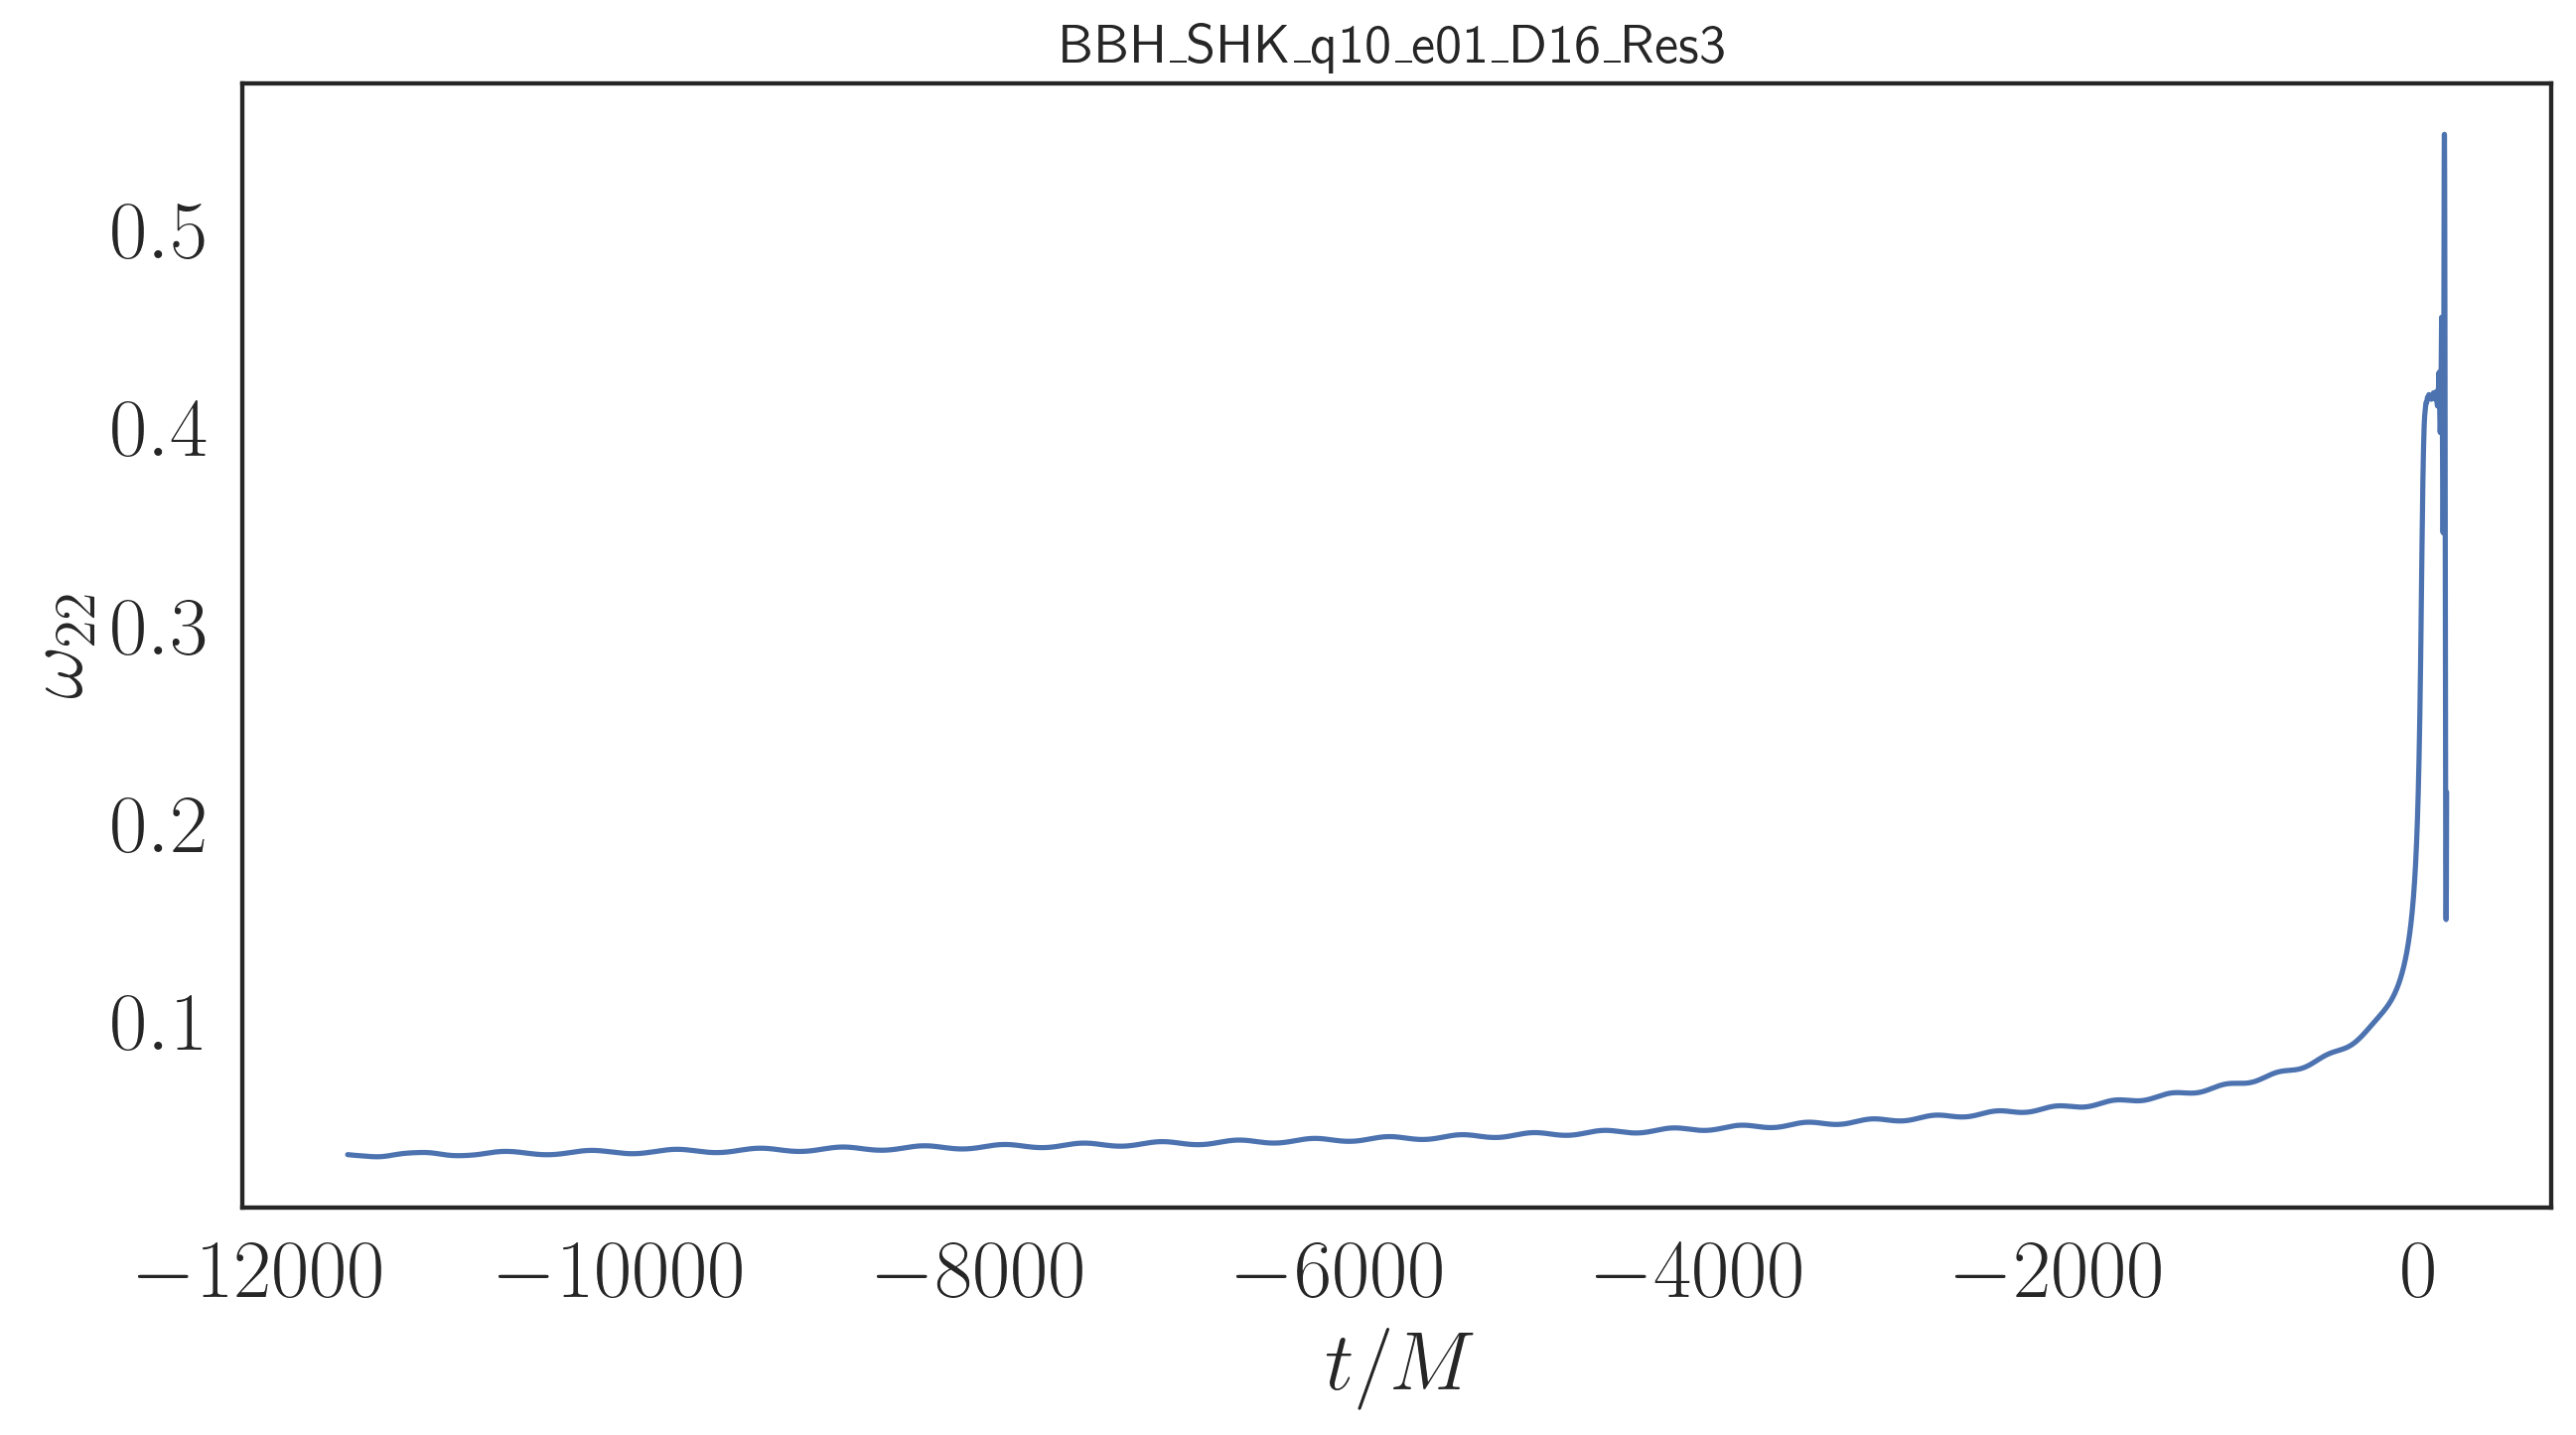

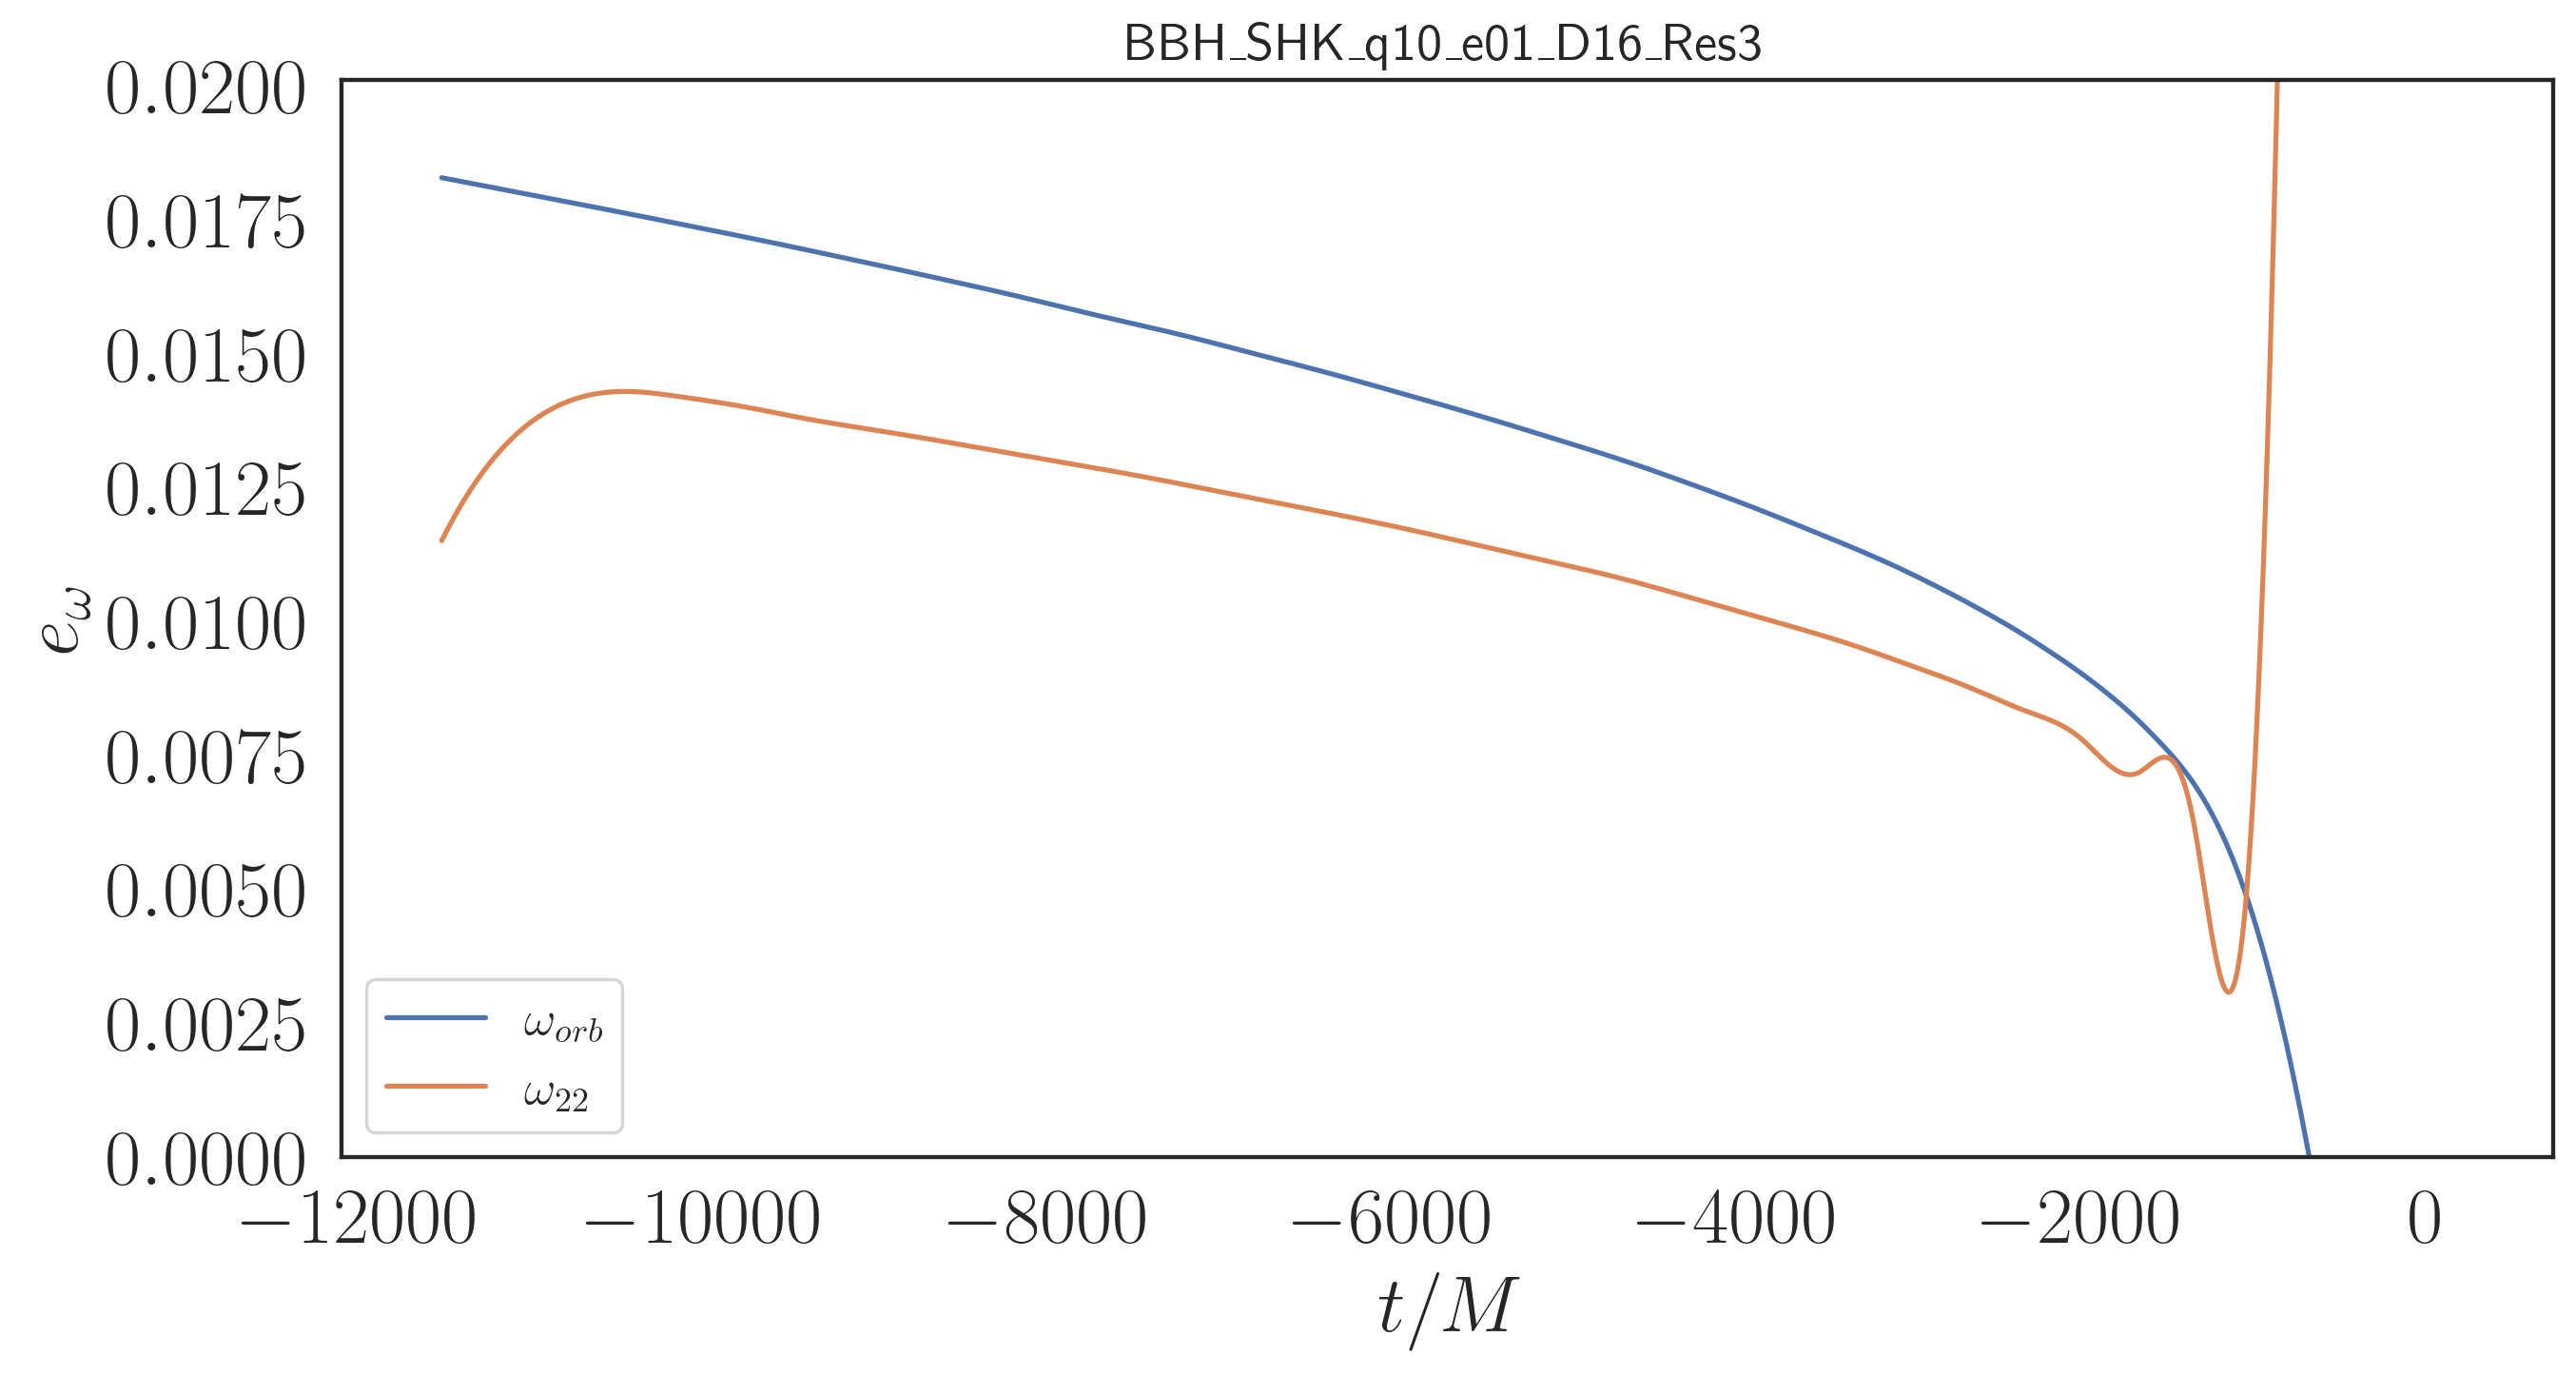

In [18]:
#plt.rcParams["figure.figsize"] = (14,10)

plt.figure(figsize=(12,6),dpi=250) 

plt.plot(timeNR,omegalm[2,2])

#plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$\omega_{22}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 

#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()

plt.figure(figsize=(12,6),dpi=250) 
plt.plot(tHorizon,ecc_omegaorb,label = r'$\omega_{orb}$')
plt.plot(timeNR,ecc_omega22,label = r'$\omega_{22}$')

plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$e_{\omega}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 
plt.ylim(0,ecc_omegaorb[0]+0.1*ecc_omegaorb[0])
#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()

In [42]:
# Compute the same for the EinsteinToolkit (ET) simulation (No trajectory data available)

In [19]:
# Set paths for the code below 
sim_dir = '/home/antoniramosbuades/git/eccentricitySXS/notebook/etask_force/'
#run_dir = sim_dir + 'AEI_sxs_sims/'
#run_dir = sim_dir +'EOB_ns_data_for_sur/'
run_dir = sim_dir +'ET_sims/'

# Choose Modes to take into account currently all l<= 8 modes
ModeList = []
lMax=6
for l in np.arange(2,lMax+1):
    for m in np.arange(-l,l+1):
        ModeList.append([l,m])
        #ModeList.append([l,-m])
        
cases = glob.glob(run_dir+"*h5")

In [20]:
# Read one ET simulation 
ii=0

nr_file = cases[ii]
simName=os.path.basename(nr_file).split('.h5')[0]

print(simName)

sim_type='ET'

# Read 22 mode from the NR file
timeNR, tHorizon, hlm, amplm, phaselm, omegalm, omega_orb, phase_orb = compute_h22OmegaOrbfromNRfile(nr_file, 
                                                                                                     ModeList,
                                                                                                sim_type)
# Below some rough example on how to compute the eccentricity (not very )
# Compute from the orbital frequency 

tNR_maxima, omega_maxima, tNR_minima, omega_minima =  compute_MaxMin22(timeNR, omegalm[2,2], amplm[2,2])

# This does not work very well close to the boundaries (need to be improved)
iphase_22 = InterpolatedUnivariateSpline(timeNR, phaselm[2,2])
iomega_22_maxima = InterpolatedUnivariateSpline(tNR_maxima, omega_maxima)
iomega_22_minima = InterpolatedUnivariateSpline(tNR_minima, omega_minima)
omega22_maxima = iomega_22_maxima(timeNR)
omega22_minima = iomega_22_minima(timeNR)
ecc_omega22 = (np.sqrt(omega22_maxima)-np.sqrt(omega22_minima))/(np.sqrt(omega22_maxima)+np.sqrt(omega22_minima))


Ecc_q2._0_0_0_0_0_0_et0.2_D16_G80L_LFr_LB_NRPsi4_Strain_60modes


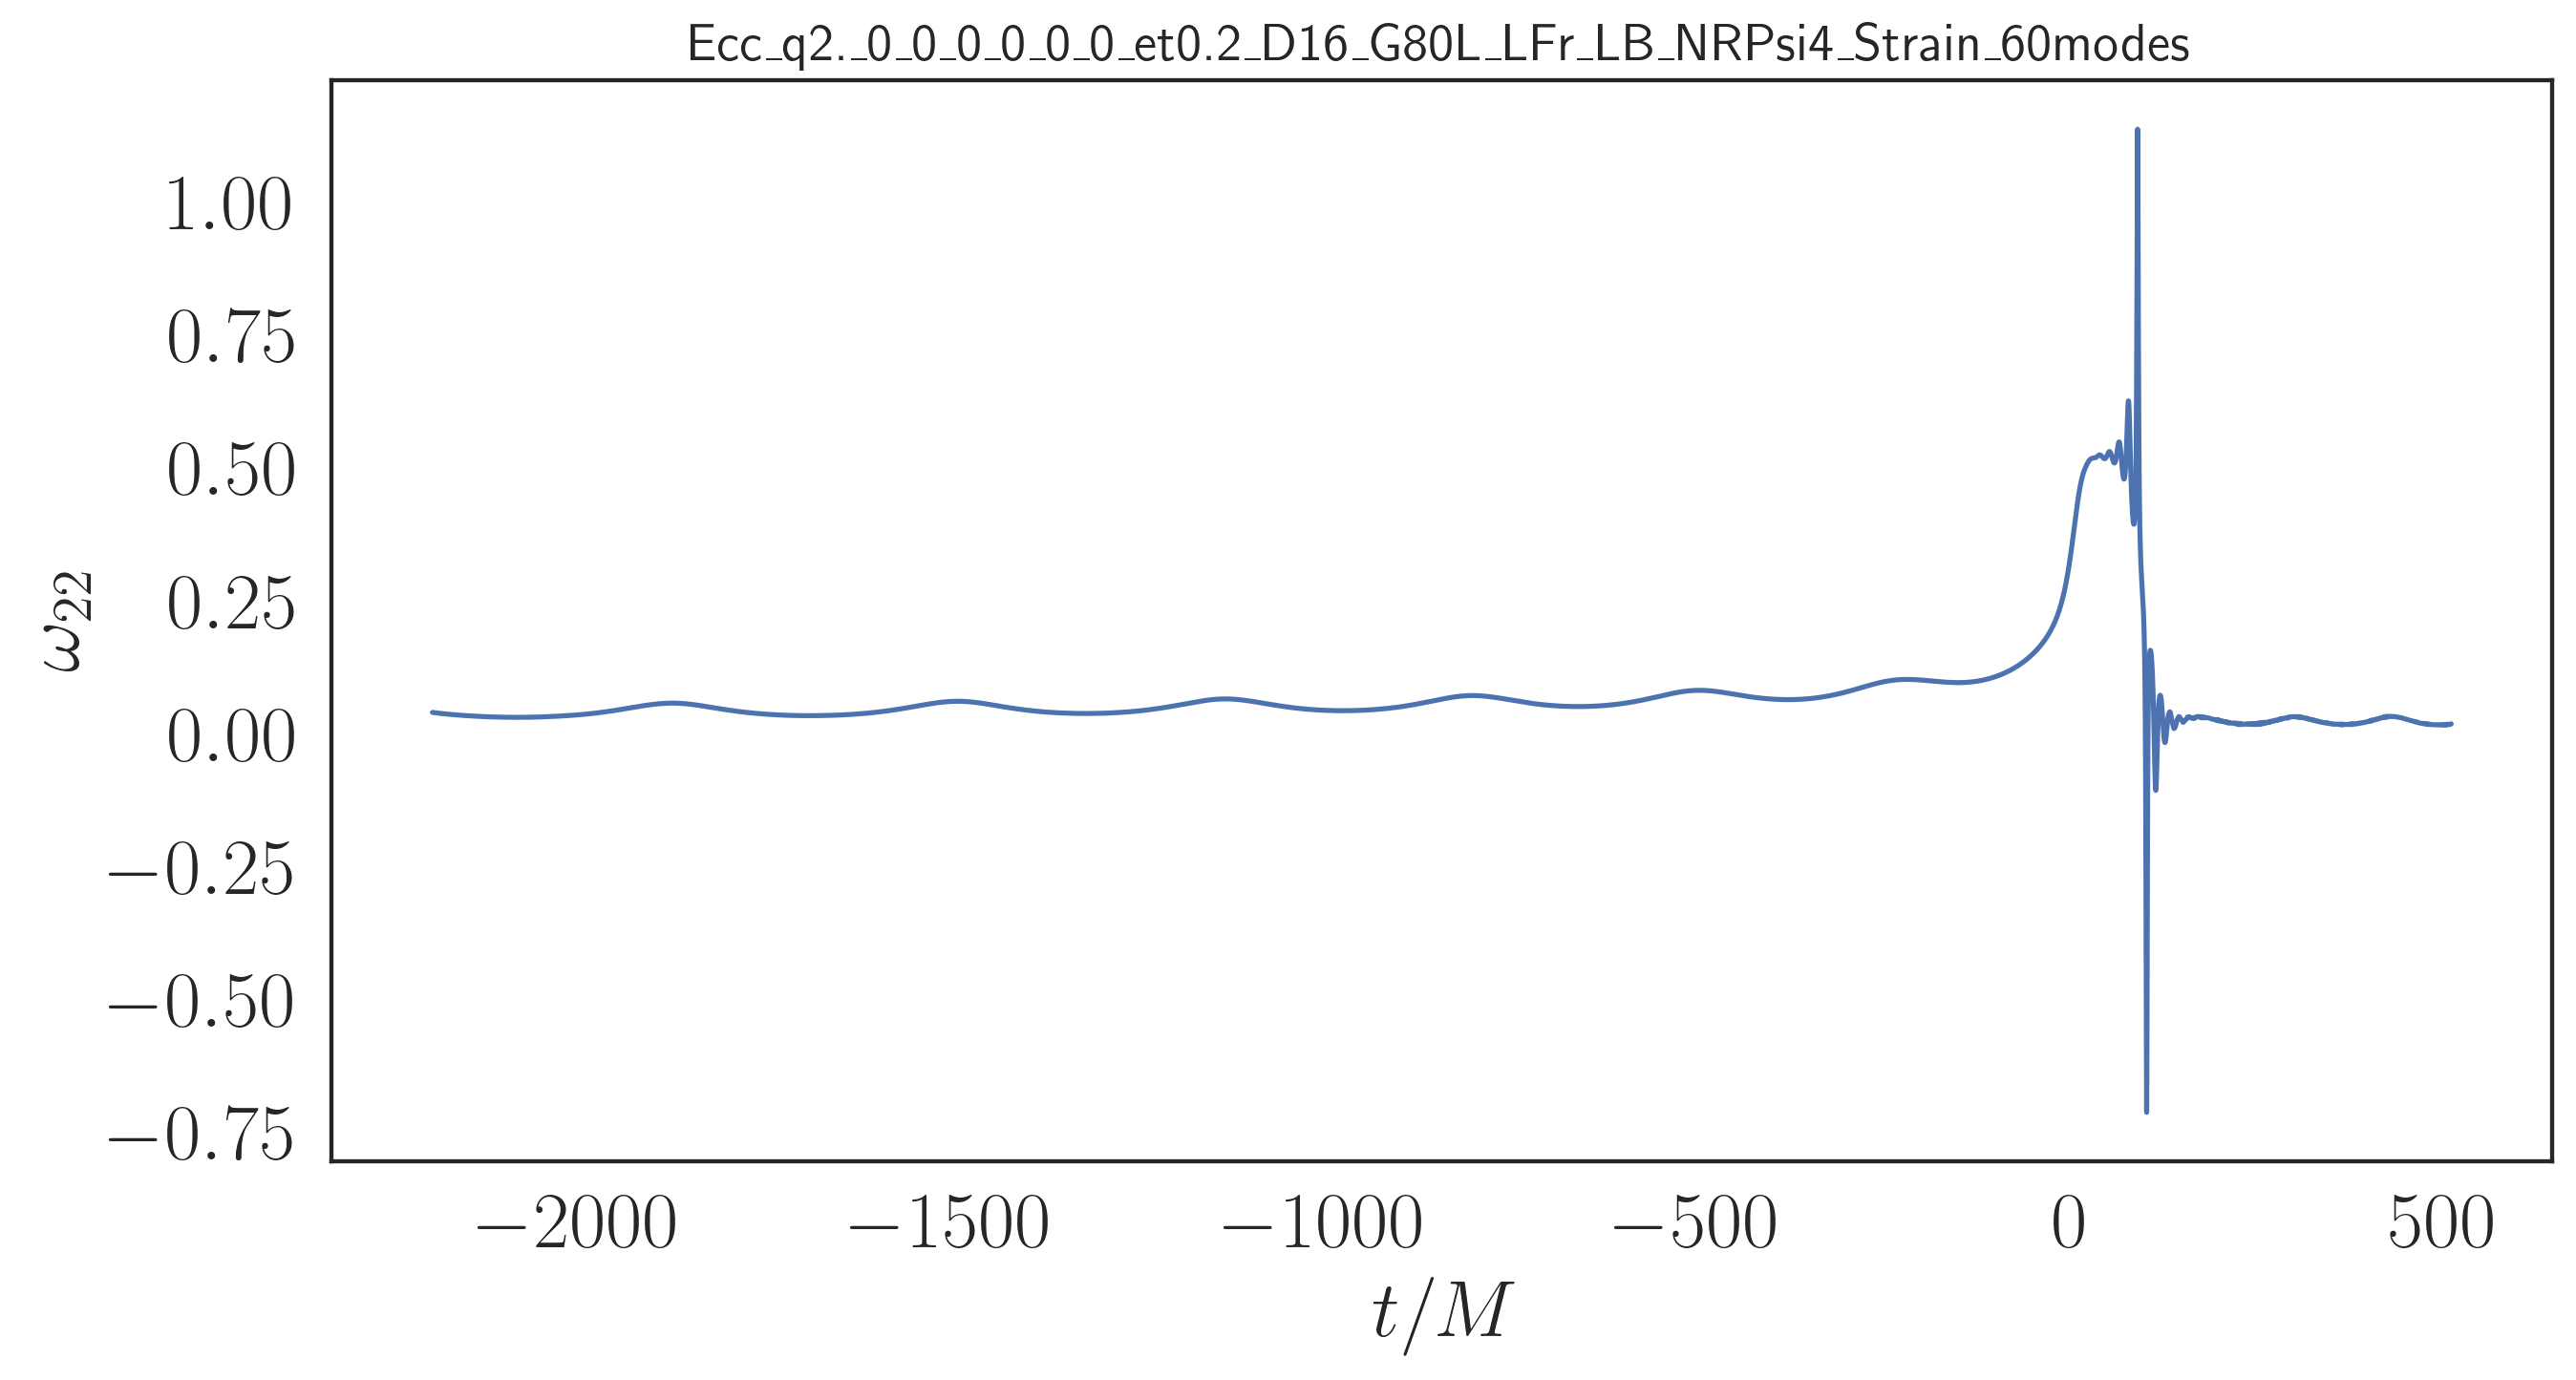

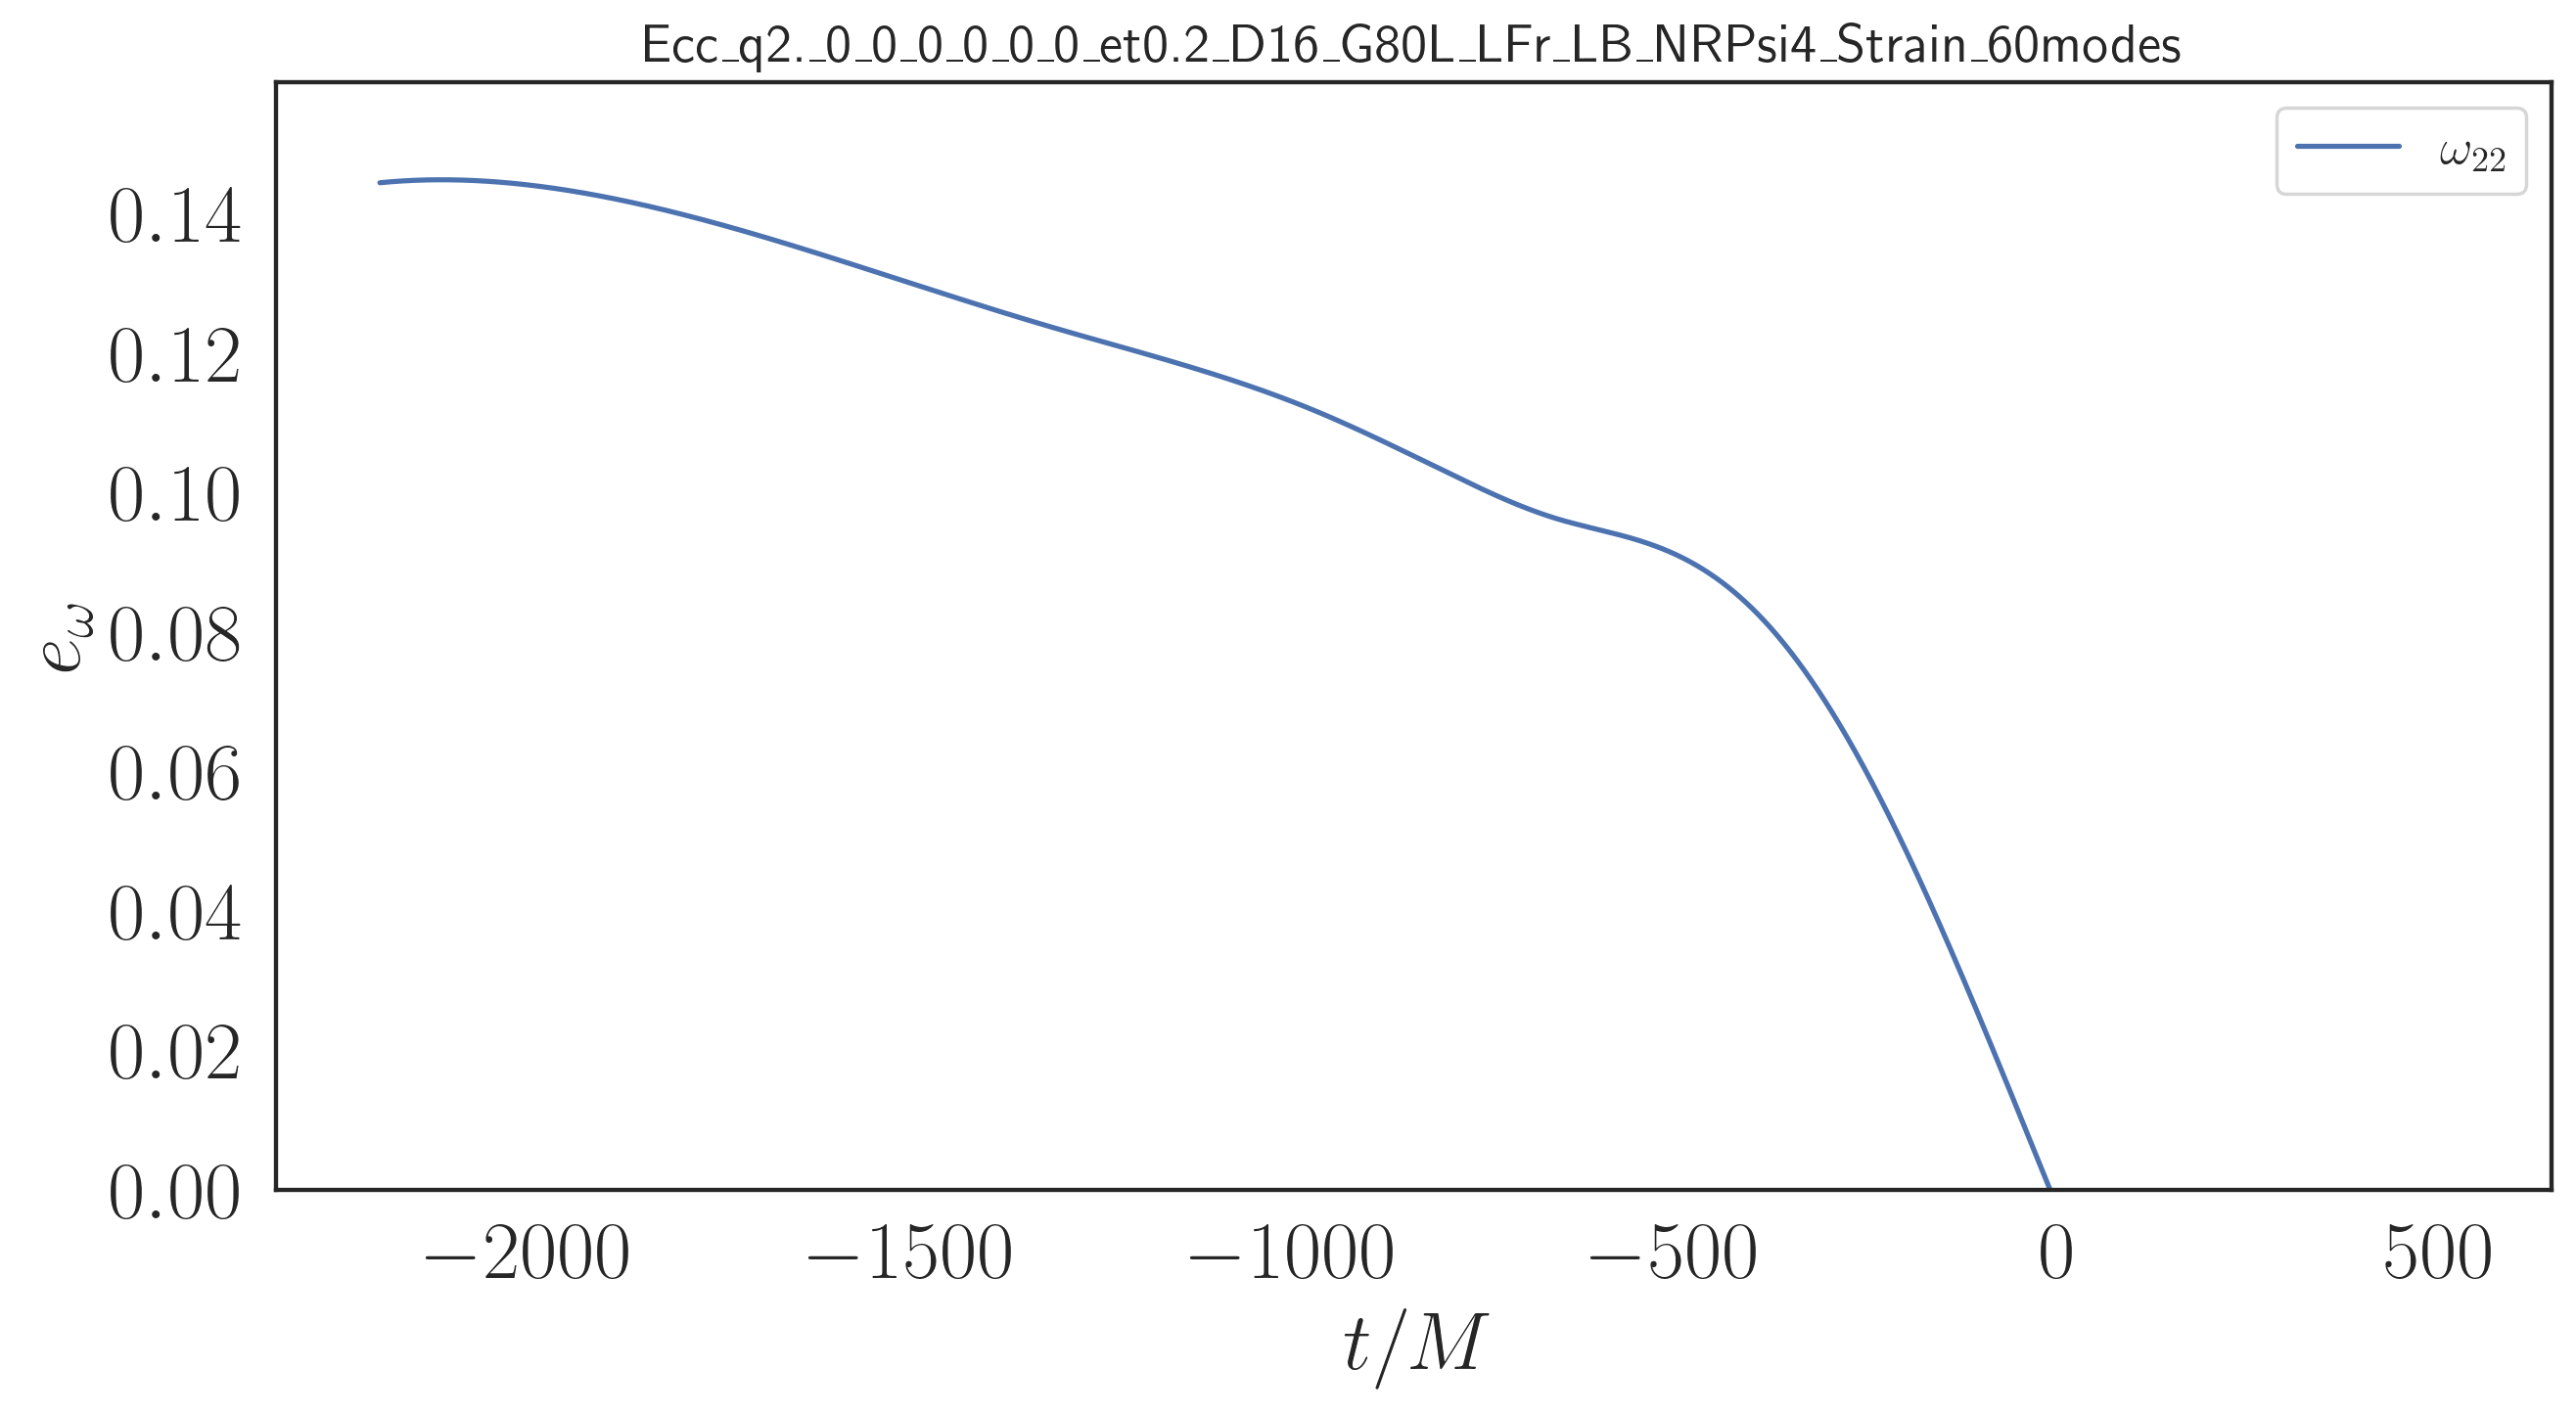

In [21]:
#plt.rcParams["figure.figsize"] = (14,10)

plt.figure(figsize=(12,6),dpi=250) 

plt.plot(timeNR,omegalm[2,2])

#plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$\omega_{22}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 

#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()

plt.figure(figsize=(12,6),dpi=250) 
plt.plot(timeNR,ecc_omega22,label = r'$\omega_{22}$')

plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$e_{\omega}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 
plt.ylim(0,ecc_omega22[0]+0.1*ecc_omega22[0])
#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()

In [81]:
# Read EOB waveform

In [24]:
# Set paths for the code below 
sim_dir = '/home/antoniramosbuades/git/eccentricitySXS/notebook/etask_force/'
run_dir = sim_dir +'EOB_ns_data_for_sur/'
#run_dir = sim_dir +'ET_sims/'

# Choose Modes to take into account currently all l<= 8 modes
      
cases = glob.glob(run_dir+"*h5")

# Read one EOB simulation 
ii=0

eob_file = cases[ii]
simName=os.path.basename(eob_file).split('.h5')[0]

print(simName)

Case_00007


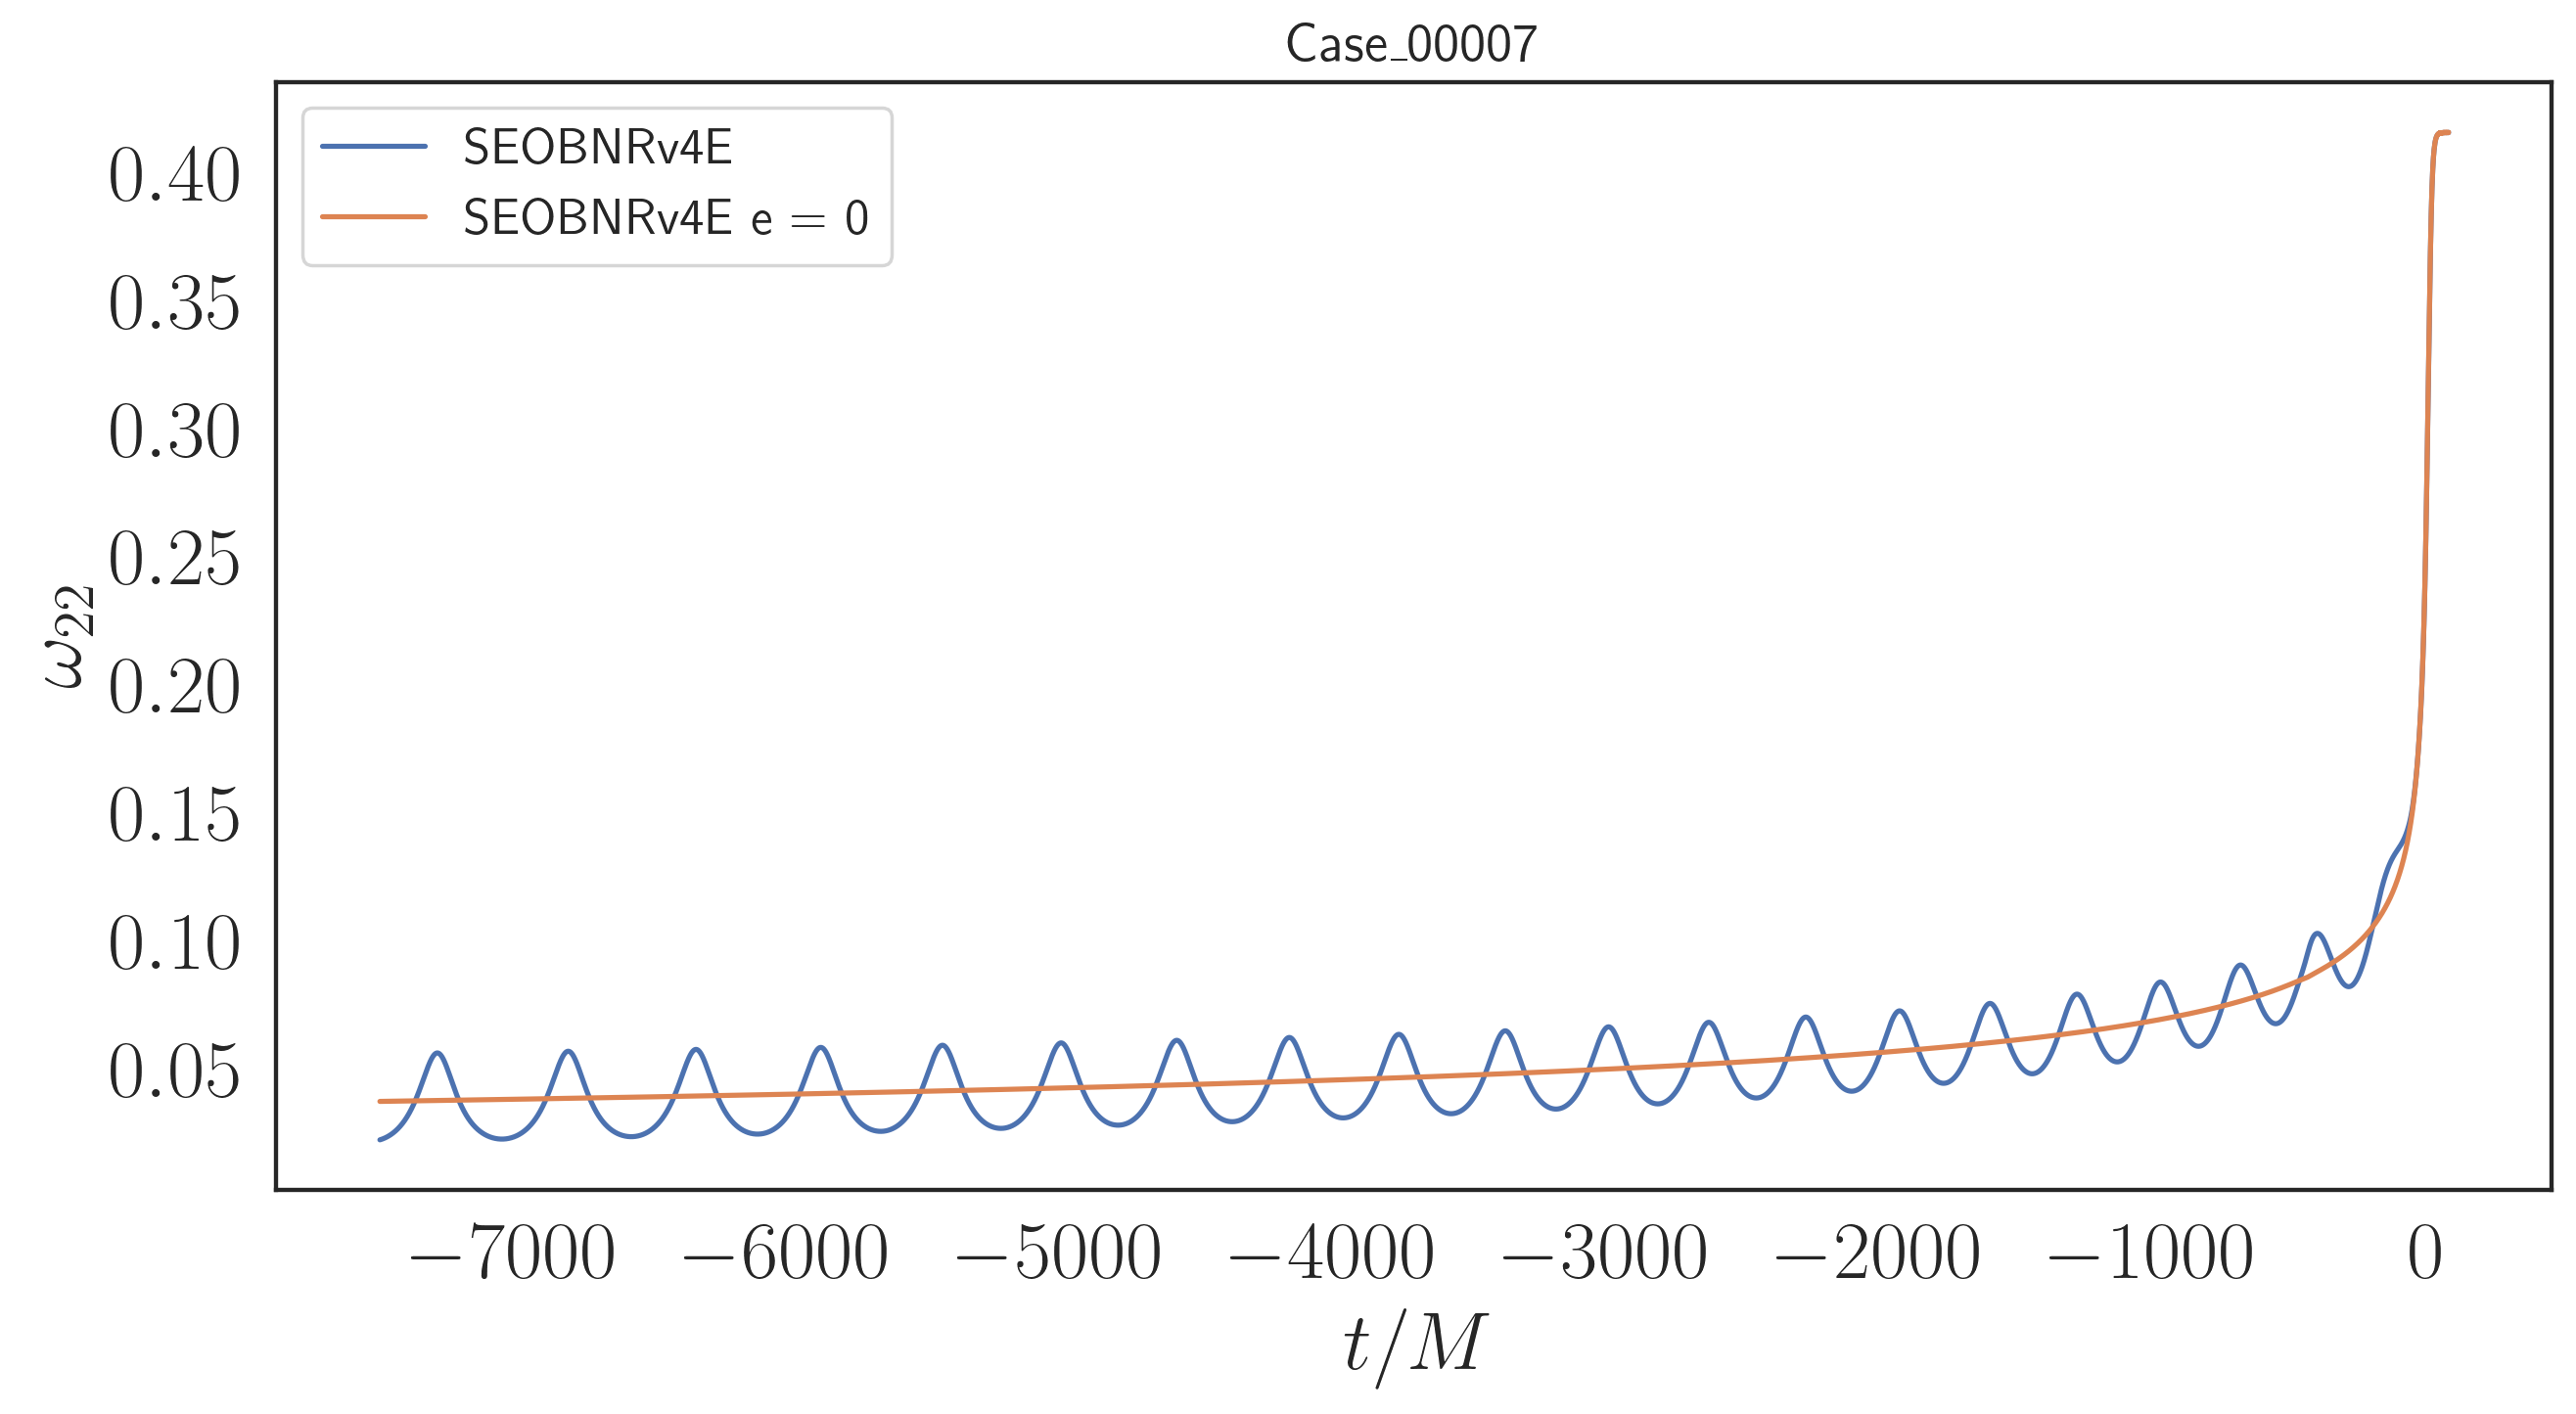

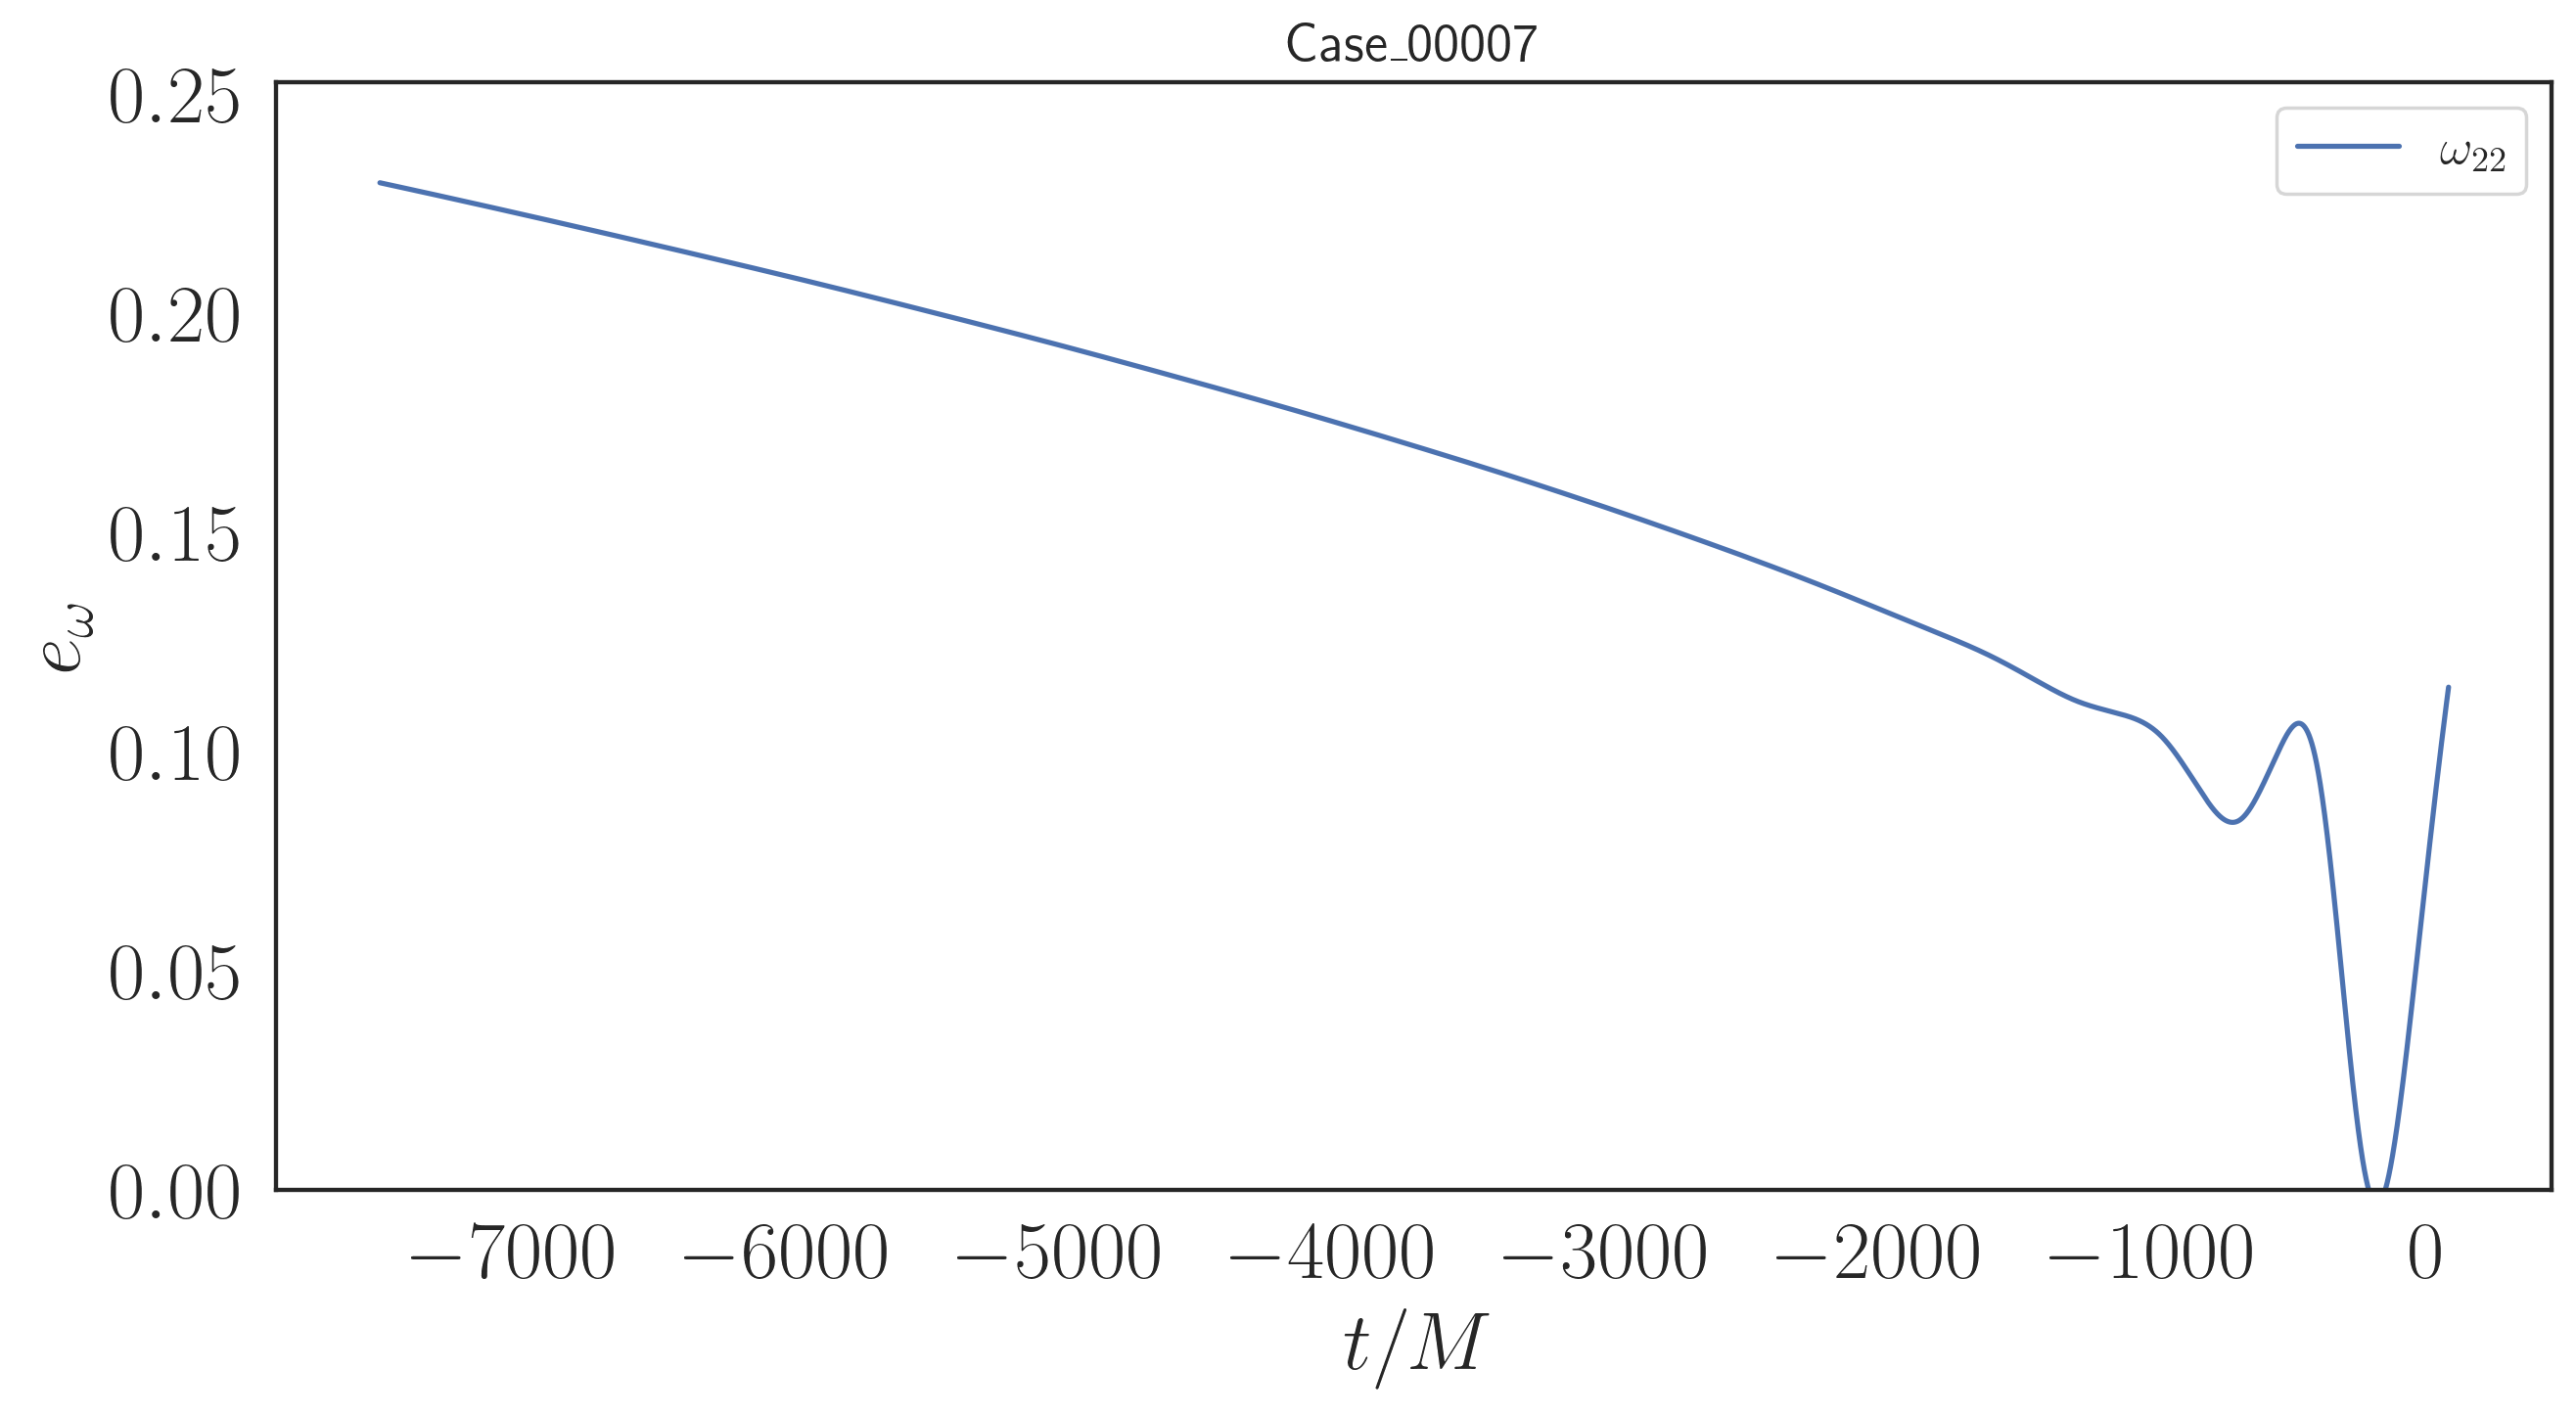

In [25]:
# Read 22 mode from the EOB file, including the eccentric 
# and the non-eccentric waveform (useful to compute the amplitude residual )
t_ecc, amp22_ecc, phi22_ecc, omega22_ecc,\
t_nonecc, amp22_nonecc, phi22_nonecc, omega22_nonecc = compute_h22fromEOBfile(eob_file)


amp22_res = amp22_ecc - amp22_nonecc

# Below some rough example on how to compute the eccentricity

# Compute from the orbital frequency 

tNR_maxima, omega_maxima, tNR_minima, omega_minima =  compute_MaxMin22(t_ecc, omega22_ecc, amp22_res)

#iomega22_ecc = InterpolatedUnivariateSpline(t_ecc,omega22_ecc)
#iomega22_ecc = InterpolatedUnivariateSpline(t_ecc,omega22_ecc)
#omega_maxima = 
# This does not work very well close to the boundaries (need to be improved)
iphase_22 = InterpolatedUnivariateSpline(t_ecc, phi22_ecc)
iomega_22_maxima = InterpolatedUnivariateSpline(tNR_maxima, omega_maxima)
iomega_22_minima = InterpolatedUnivariateSpline(tNR_minima, omega_minima)
omega22_maxima = iomega_22_maxima(t_ecc)
omega22_minima = iomega_22_minima(t_ecc)
ecc_omega22 = (np.sqrt(omega22_maxima)-np.sqrt(omega22_minima))/(np.sqrt(omega22_maxima)+np.sqrt(omega22_minima))



plt.figure(figsize=(12,6),dpi=250) 

plt.plot(t_ecc,omega22_ecc,label='SEOBNRv4E')
plt.plot(t_nonecc,omega22_nonecc,label='SEOBNRv4E e = 0')

plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$\omega_{22}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 

#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()

plt.figure(figsize=(12,6),dpi=250) 
plt.plot(t_ecc,ecc_omega22,label = r'$\omega_{22}$')

plt.legend(loc='best', prop={'size': 15}, ncol=1)
plt.xlabel(r'$t/M$',fontsize=24)
plt.ylabel(r'$e_{\omega}$',fontsize=24)

             
plt.title(simName,fontsize=16)
#plt.grid(b=None)
plt.xticks(fontsize=24) 
plt.yticks(fontsize=24) 
plt.ylim(0,ecc_omega22[0]+0.1*ecc_omega22[0])
#plt.savefig(outdir+'/plot_TrajectoryOrb_y_z.png')

plt.show()
plt.close()